In [91]:
import findspark
findspark.init()

In [92]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

spark=SparkSession.builder \
.master ("local[*]")\
.appName("week3")\
.getOrCreate()
sc=spark.sparkContext
sqlContext=SQLContext(sc)

C:\Program Files\spark\spark\python\pyspark\sql\context.py:112: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



In [93]:
df=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",";")\
 .csv("XYZ_Bank_Deposit_Data_Classification.csv")

df.show(n=1, vertical=True)

-RECORD 0---------------------
 age            | 56          
 job            | housemaid   
 marital        | married     
 education      | basic.4y    
 default        | no          
 housing        | no          
 loan           | no          
 contact        | telephone   
 month          | may         
 day_of_week    | mon         
 duration       | 261         
 campaign       | 1           
 pdays          | 999         
 previous       | 0           
 poutcome       | nonexistent 
 emp.var.rate   | 1.1         
 cons.price.idx | 93.994      
 cons.conf.idx  | -36.4       
 euribor3m      | 4.857       
 nr.employed    | 5191.0      
 y              | no          
only showing top 1 row



In [94]:
# remove . from column names to make easier to work with
new_names = [i.replace('.', '') for i in df.columns]
df = df.toDF(*new_names)

## Summary Statistics

### Null Values

In [33]:
from pyspark.sql.functions import col,isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show(vertical=True)

-RECORD 0-----------
 age          | 0   
 job          | 0   
 marital      | 0   
 education    | 0   
 default      | 0   
 housing      | 0   
 loan         | 0   
 contact      | 0   
 month        | 0   
 day_of_week  | 0   
 duration     | 0   
 campaign     | 0   
 pdays        | 0   
 previous     | 0   
 poutcome     | 0   
 empvarrate   | 0   
 conspriceidx | 0   
 consconfidx  | 0   
 euribor3m    | 0   
 nremployed   | 0   
 y            | 0   



### Numerical Features

In [34]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double']
numeric_features

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'empvarrate',
 'conspriceidx',
 'consconfidx',
 'euribor3m',
 'nremployed']

In [35]:
df.select(numeric_features).describe().show(vertical=True)

-RECORD 0---------------------------
 summary      | count               
 age          | 41188               
 duration     | 41188               
 campaign     | 41188               
 pdays        | 41188               
 previous     | 41188               
 empvarrate   | 41188               
 conspriceidx | 41188               
 consconfidx  | 41188               
 euribor3m    | 41188               
 nremployed   | 41188               
-RECORD 1---------------------------
 summary      | mean                
 age          | 40.02406040594348   
 duration     | 258.2850101971448   
 campaign     | 2.567592502670681   
 pdays        | 962.4754540157328   
 previous     | 0.17296299893172767 
 empvarrate   | 0.08188550063178966 
 conspriceidx | 93.5756643682899    
 consconfidx  | -40.502600271918276 
 euribor3m    | 3.621290812858533   
 nremployed   | 5167.035910943957   
-RECORD 2---------------------------
 summary      | stddev              
 age          | 10.421249980934043  
 

### Categorical Features

In [36]:
categorical_features = [t[0] for t in df.dtypes if t[1] == 'string']
categorical_features

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome',
 'y']

In [37]:
df.select(categorical_features).describe().show(vertical=True)

-RECORD 0----------------
 summary     | count     
 job         | 41188     
 marital     | 41188     
 education   | 41188     
 default     | 41188     
 housing     | 41188     
 loan        | 41188     
 contact     | 41188     
 month       | 41188     
 day_of_week | 41188     
 poutcome    | 41188     
 y           | 41188     
-RECORD 1----------------
 summary     | mean      
 job         | null      
 marital     | null      
 education   | null      
 default     | null      
 housing     | null      
 loan        | null      
 contact     | null      
 month       | null      
 day_of_week | null      
 poutcome    | null      
 y           | null      
-RECORD 2----------------
 summary     | stddev    
 job         | null      
 marital     | null      
 education   | null      
 default     | null      
 housing     | null      
 loan        | null      
 contact     | null      
 month       | null      
 day_of_week | null      
 poutcome    | null      
 y          

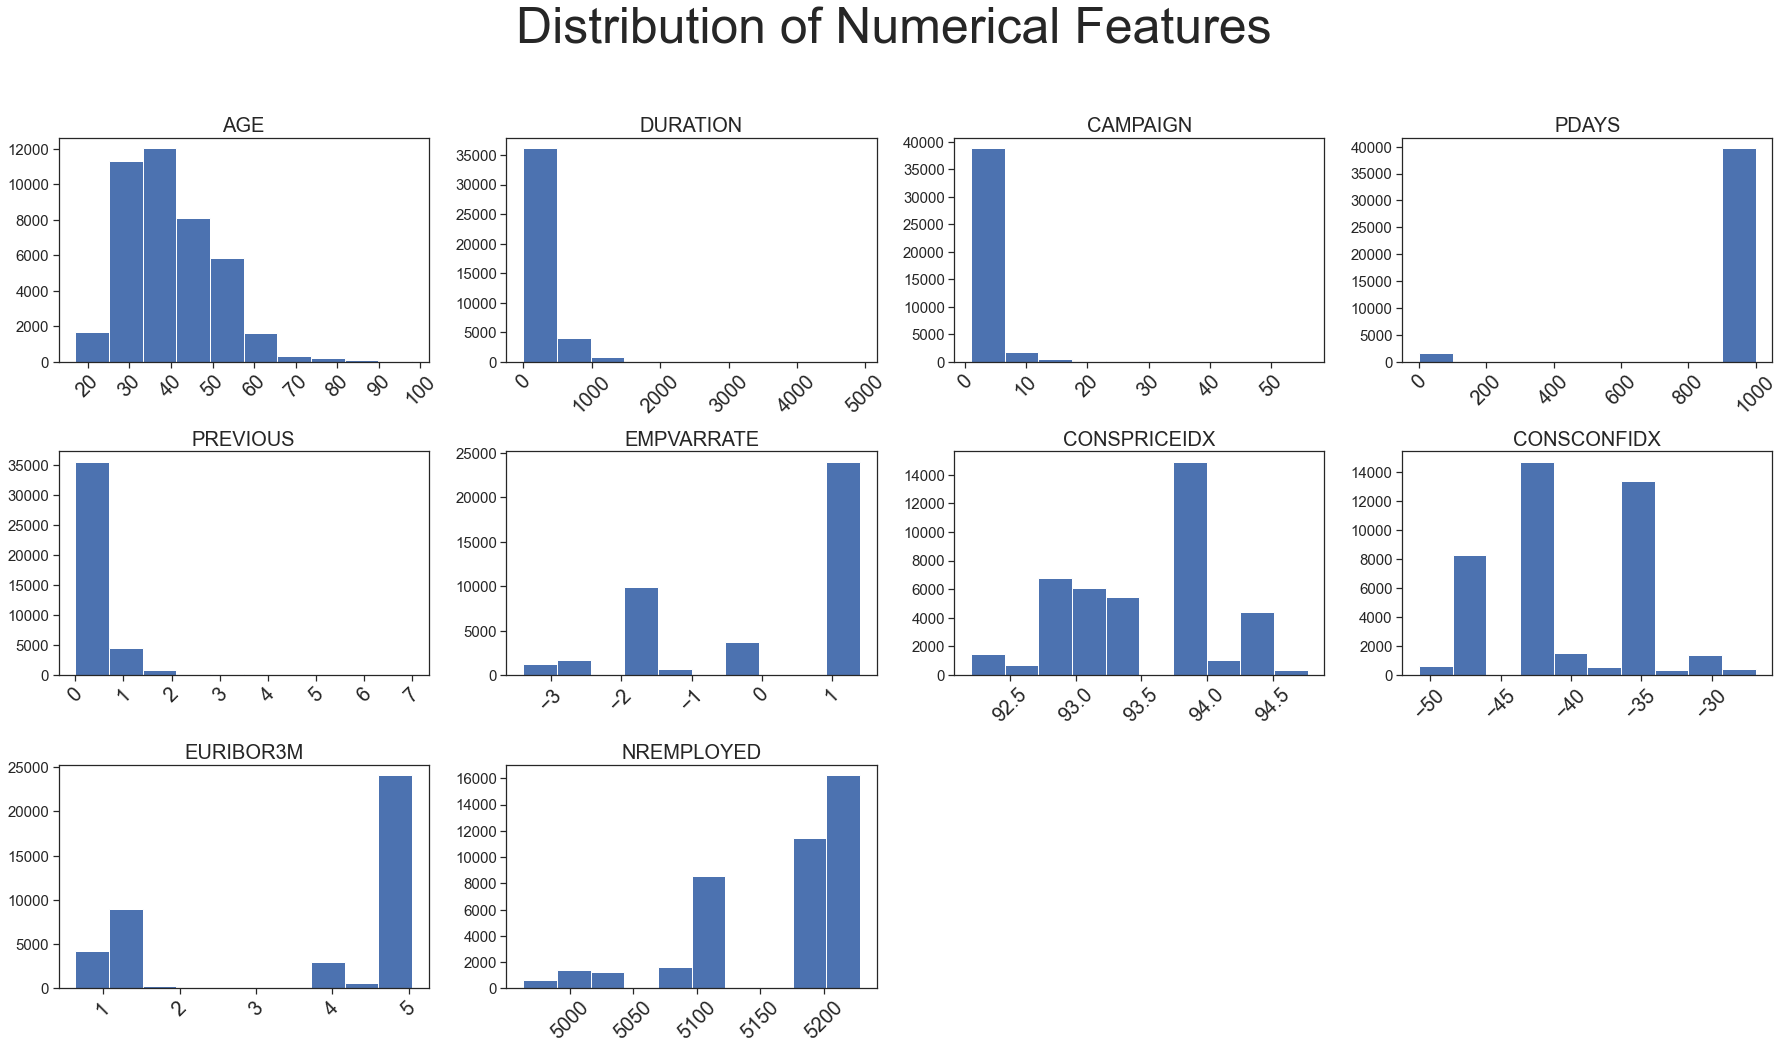

In [29]:
from matplotlib import cm
fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Distribution of Numerical Features", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(df.toPandas().describe().columns, range(1,11)):
    ax = fig.add_subplot(3,4,num)
    ax.hist(df.toPandas()[col])
    #plt.style.use('dark_background') 
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

## Correlation

In [30]:
from pyspark.mllib.stat import Statistics
import pandas as pd

corr_data = df.select(numeric_features)

col_names = corr_data.columns
features = corr_data.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

print(corr_df.to_string())

                   age  duration  campaign     pdays  previous  empvarrate  conspriceidx  consconfidx  euribor3m  nremployed
age           1.000000 -0.000866  0.004594 -0.034369  0.024365   -0.000371      0.000857     0.129372   0.010767   -0.017725
duration     -0.000866  1.000000 -0.071699 -0.047577  0.020640   -0.027968      0.005312    -0.008173  -0.032897   -0.044703
campaign      0.004594 -0.071699  1.000000  0.052584 -0.079141    0.150754      0.127836    -0.013733   0.135133    0.144095
pdays        -0.034369 -0.047577  0.052584  1.000000 -0.587514    0.271004      0.078889    -0.091342   0.296899    0.372605
previous      0.024365  0.020640 -0.079141 -0.587514  1.000000   -0.420489     -0.203130    -0.050936  -0.454494   -0.501333
empvarrate   -0.000371 -0.027968  0.150754  0.271004 -0.420489    1.000000      0.775334     0.196041   0.972245    0.906970
conspriceidx  0.000857  0.005312  0.127836  0.078889 -0.203130    0.775334      1.000000     0.058986   0.688230    0.522034


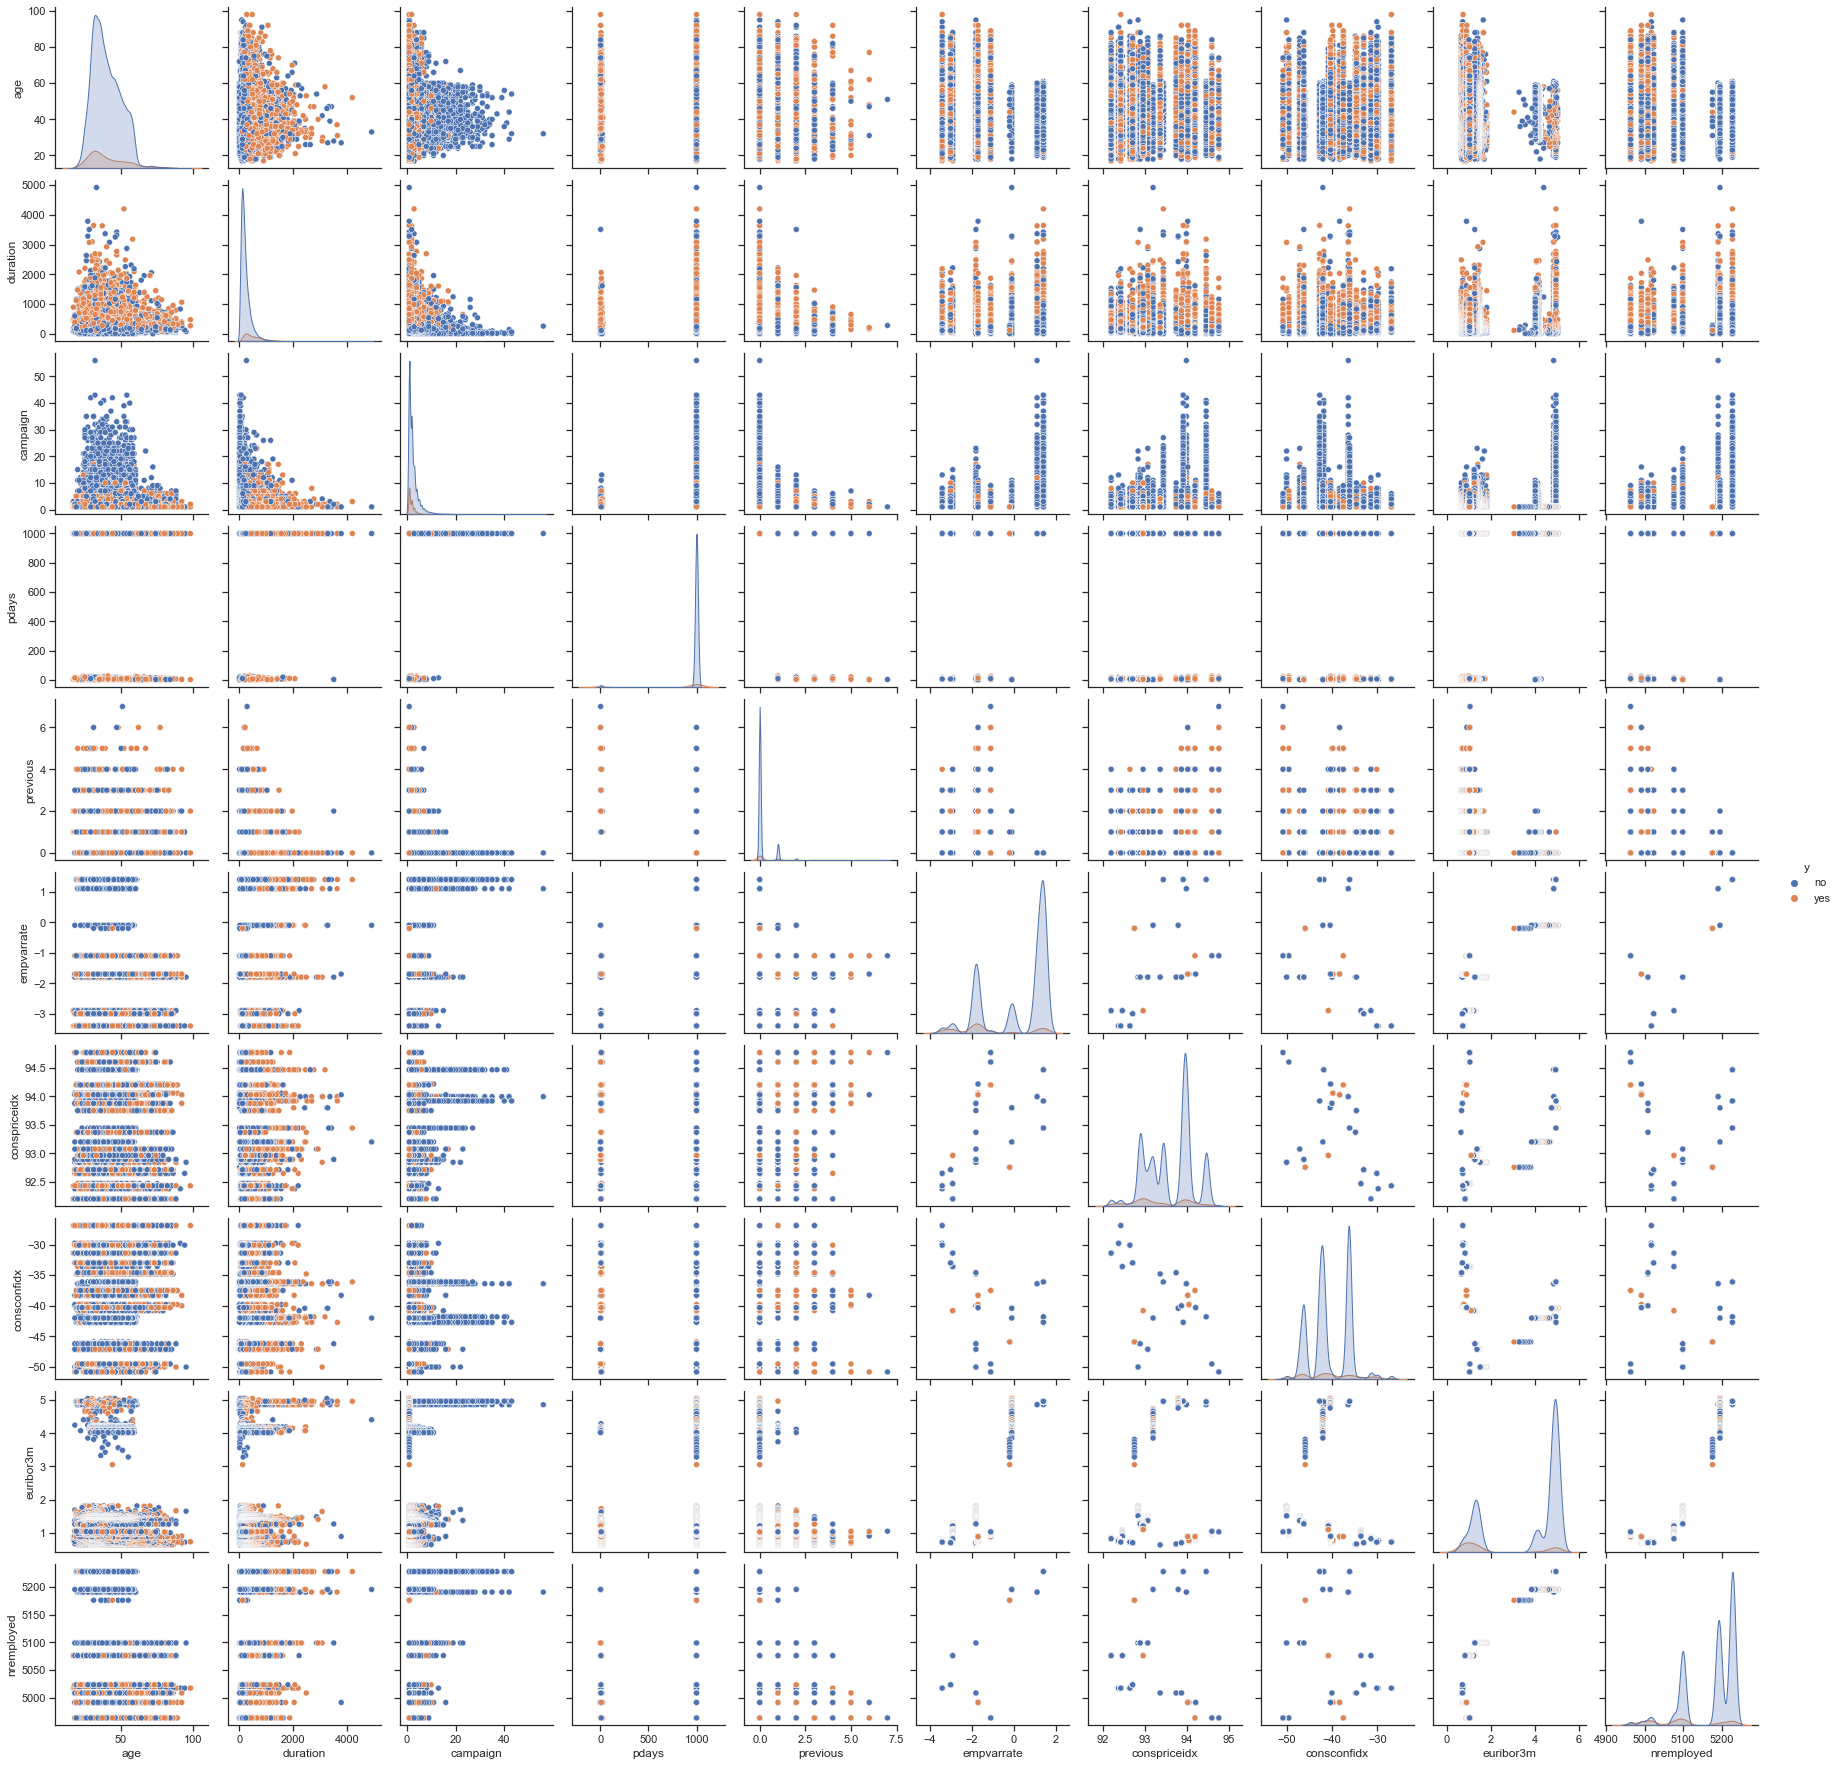

In [40]:
import seaborn as sns
sns.set(style="ticks")

sns.pairplot(df.toPandas(), hue="y")
plt.show()

## Input Variables (Numerical) relationship with Target Variable

### Age relation with clients who will subscribe (y)

In [69]:
import plotly.express as px
fig = px.histogram(df.toPandas(), x="age", color="y")
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
fig.show()

In [71]:
import plotly.express as px
fig = px.histogram(df.toPandas(), x="duration", color="y")
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
fig.show()

In [73]:
import plotly.express as px
fig = px.histogram(df.toPandas(), x="campaign", color="y")
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
fig.show()

In [74]:
import plotly.express as px
fig = px.histogram(df.toPandas(), x="pdays", color="y")
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
fig.show()

In [75]:
import plotly.express as px
fig = px.histogram(df.toPandas(), x="previous", color="y")
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
fig.show()

In [76]:
import plotly.express as px
fig = px.histogram(df.toPandas(), x="duration", color="y")
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
fig.show()